<a href="https://colab.research.google.com/github/AndreAmaduzzi/tensorflow-vs-pytorch/blob/main/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch implementation of Object Detection Network

## Import Dependencies

In [86]:
!pip install xmltodict
from __future__ import print_function
from __future__ import division

import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import os
import time

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from timeit import default_timer as timer
from typing import Callable, Dict, List, Tuple, Union
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import xml.etree.ElementTree as ET
import xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Runtime Settings

In [87]:
device = "cpu"
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')

All good, a Gpu is available


## Reproducibility and Deterministic Mode

In [88]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=7)

## Building Dataset
Dataset: [BCCD dataset](https://public.roboflow.com/object-detection/bccd)

3 classes (white blood cells, red blood cells, platelets)

364 images

In [89]:
! git clone https://github.com/Shenggan/BCCD_Dataset.git
%cd "BCCD_Dataset/"

fatal: destination path 'BCCD_Dataset' already exists and is not an empty directory.
/content/BCCD_Dataset/BCCD_Dataset


In [90]:
!ls

BCCD	      dataset	   export.py  LICENSE  README.md  test.csv
BCCD_Dataset  example.jpg  imagesBox  plot.py  scripts


In [91]:
def parse_annotations_file(path_annotations):
  return 0

In [101]:
class BCCDDataset(Dataset):
    def __init__(
        self,
        split: str,
        path_images: str,
        ext_images: str,
        path_annotations: str,
        path_splits: str,
        transforms: torchvision.transforms = None,
    ) -> None:
        """Init the dataset

        Args:
            path_images: the path to the folder containing the images.
            ext_images: extension of the images.
            path_annotations: the path to the folder containing the annotations.
            path_splits: the path with the image names for each split
            transforms: the transformation to apply to the dataset.
        """
        imgs = []
        imgs_path = os.path.join(path_splits, f"{split}.txt")
        with open(imgs_path, "r") as f:
          for line in f:
            img = line.rstrip()
            imgs.append(img)

        self.images = sorted([os.path.join(path_images, img + f".{ext_images}") for img in imgs])  # path of each image
                
        self.transforms = transforms

        self.classes = ["__background__", "RBC", "WBC", "Platelets"]

        # build annotations
        path_annotations = sorted([os.path.join(path_annotations, img + ".xml") for img in imgs])

        samples = []
        for path in path_annotations: # iterate over each xml => each image
          tree = ET.parse(path)
          root = tree.getroot()
          detections = []
          for child in root:
            sample = {}
            if child.tag == "object":
              detection = {}
              for grandchild in child: # iterate over attributes of the object
                if grandchild.tag=="name":
                  name = grandchild.text
                  detection["name"] = name
                  detection["label"] = self.classes.index(name)
                if grandchild.tag=="bndbox":
                  xmin = float(grandchild[0].text)
                  ymin = float(grandchild[1].text)
                  xmax = float(grandchild[2].text)
                  ymax = float(grandchild[3].text)
                  detection["bbox"] = (xmin, ymin, xmax, ymax)
              detections.append(detection)
          sample["img"] = path
          sample["detections"] = detections
          samples.append(sample)

        self.annotations = samples

        if len(self.images) - len(self.annotations) != 0:
            raise AssertionError(
                f"Labels and Images differs in size: {len(self.images)} - {len(self.annotations)}."
            )

    def __getitem__(self, idx):
        path_image = self.images[idx]
        image = Image.open(path_image).convert("RGB")
      
        if self.transforms is not None:
            image = self.transforms(image)

        target = self.annotations[idx]["detections"]  # target is a list of dictionaries with keys "name", "label" and "bbox"

        return image, target

    def __len__(self):
        return len(self.images)

In [102]:
# Setting data loading parameters
bs = 28
n_workers = 2
img_transformations = transforms.ToTensor()   # transformations to apply to the input images

In [103]:
def draw_boxes(image: Image,
               targets: Dict,
               scores: List[float],
               colors: List[List[float]],
               normalized_coordinates: bool,
               add_text: bool = True) -> Image:
    """Draws a rectangle around each object together with the name of the category and the prediction score using a 
    different color for each category.

    Args:
        image: the input image.
        boxes: the bounding boxes in the format [x_min, y_min, x_max, y_max] 
               for all the objects in the image.
        classes: the name of the classes for all the objects in the image.
        labels: the labels for all the objects in the image.
        scores: the predicted scores for all the objects in the image..
        colors: the colors to use for each class of object.
        normalized_coordinates: if true the coordinates are multiplied 
                                according to the height and width of the image.
        add_text: if true add a box with the name of the category and 
                  the score.

    Returns:
        The generated image.
    """
    font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', 30)
    image_with_bb = copy.deepcopy(image)
    painter = ImageDraw.Draw(image_with_bb)

    boxes = []
    labels= []
    names = []
    for target in targets:
      boxes.append(target["bbox"])
      labels.append(target["label"])
      names.append(target["name"])

    for i, (box, label) in enumerate(zip(boxes, labels)):        
        color = tuple(colors[label].astype(np.int32))
        x_min, y_min, x_max, y_max = box
        
        if normalized_coordinates:
            width, height = image.size
            x_min *= width
            y_min *= height
            x_max *= width
            y_max *= height

        coord_bb = [(x_min, y_min), (x_max, y_max)]
        painter.rectangle(coord_bb, outline=color, width=4)
        
        if add_text:            
            label = labels[i]
            score = scores[i]
            name = names[i]
            text_in_box = f'{name}-{score:.2f}'
            text_bottom = y_max
            text_width, text_height = font.getsize(text_in_box)
            margin = np.ceil(0.05 * text_height)
            painter.rectangle([(x_min, text_bottom - text_height - 2 * margin), 
                               (x_min + text_width, text_bottom)], fill=color)
            
            painter.text((x_min + margin, text_bottom - text_height - margin), 
                         text_in_box, fill='black', font=font)

    return image_with_bb

In [104]:
def generate_colors(num_colors: int) -> np.array:
    """Generates an array with RGB triplets representing colors.

    Args:
        num_colors: the number of colors to generate.

    Returns: 
        the generated colors.
    """
    np.random.seed(0)
    colors = np.random.uniform(0, 255, size=(num_colors, 3))
    time_in_ms = 1000 * time.time()
    np.random.seed(int(time_in_ms) % 2 ** 32)

    return colors

In [105]:
colors_mi = generate_colors(4)

In [106]:
train_ds = BCCDDataset(path_images = "BCCD/JPEGImages",
                            split = "train",
                            ext_images = "jpg",
                            path_annotations = "BCCD/Annotations",
                            path_splits = "BCCD/ImageSets/Main",
                            transforms=img_transformations)

val_ds = BCCDDataset(path_images = "BCCD/JPEGImages",
                            split = "val",
                            ext_images = "jpg",
                            path_annotations = "BCCD/Annotations",
                            path_splits = "BCCD/ImageSets/Main",
                            transforms=img_transformations)

test_ds = BCCDDataset(path_images = "BCCD/JPEGImages",
                            split = "test",
                            ext_images = "jpg",
                            path_annotations = "BCCD/Annotations",
                            path_splits = "BCCD/ImageSets/Main",
                            transforms=img_transformations)


In [107]:
print('train: ', len(train_ds))
print('val: ', len(val_ds))
print('test: ', len(test_ds))

train:  205
val:  87
test:  72


torch.Size([3, 480, 640])


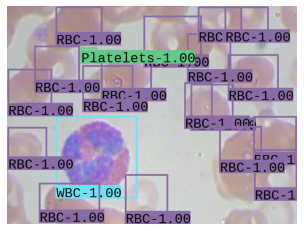

In [110]:
#@title Show BCCD Train Dataset { run: "auto", display-mode: "form" }
index_sample = 17  #@param {type:"slider", min:0, max:200, step:1}


image, targets = train_ds[index_sample]

print(img.shape)

image = transforms.ToPILImage()(image)

cell_with_bb = draw_boxes(image,
                          targets = targets,
                          scores=[1.0] * len(targets),
                          colors=colors_mi,
                          normalized_coordinates=False)
plt.imshow(cell_with_bb)
plt.axis("off")
plt.show()


## Build Network

In [111]:
# input of the network: torch Tensor image of shape 480x640
# output of the network: label and 4 float numbers, for each detection

In [ ]:
## Define the model here
### architecture
### loss

## Training

In [112]:
def train(writer: utils.tensorboard.writer.SummaryWriter,
          model: nn.Module,
          train_loader: utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim,          
          log_interval: int,
          epoch: int) -> Dict[str, float]:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.        
        log_interval: the log interval.
        epoch: the number of the current epoch.

    Returns: 
        A dictionary containing:
            the sum of classification and regression loss.
            the classification loss.
            the regression loss.
    """        
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)    

    model.train()
    for idx_batch, (images, targets) in enumerate(train_loader):        
        optimizer.zero_grad()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        
        loss_class = loss_dict['classification']
        loss_boxes_regr = loss_dict['bbox_regression']
        losses = loss_class + loss_boxes_regr
        losses.backward()
        optimizer.step()

        if log_interval > 0:
            if idx_batch % log_interval == 0:                                
                global_step = idx_batch + (epoch * num_batches)                 
                writer.add_scalar('Metrics/Loss_Train_IT_Sum', losses, global_step)         
                writer.add_scalar('Metrics/Loss_Train_IT_Boxes', loss_boxes_regr, global_step)     
                writer.add_scalar('Metrics/Loss_Train_IT_Classification', loss_class, global_step)                    
                    
    dict_losses_train = {'bbox_regression': loss_boxes_regr,
                         'classification': loss_class,
                         'sum': losses}
    return dict_losses_train


In [113]:
def training_loop(writer: utils.tensorboard.writer.SummaryWriter,
                  num_epochs: int,
                  optimizer: torch.optim, 
                  lr_scheduler: torch.optim.lr_scheduler,
                  log_interval: int, 
                  model: nn.Module, 
                  loader_train: utils.data.DataLoader, 
                  loader_val: utils.data.DataLoader, 
                  verbose: bool=True) -> Dict[str, List[float]]:
    """Executes the training loop.
    
        Args:
            writer: the summary writer for tensorboard.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            lr_scheduler: the scheduler for the learning rate.
            log_interval: intervall to print on tensorboard.
            model: the model to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the train accuracy for each epoch.            
            the time of execution in seconds for the entire loop.
            the model trained 
    """    
    loop_start = timer()

    losses_val_bb = []
    losses_val_class = []
    losses_val_sum = []
    
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        losses_epoch_train = train(writer, model, loader_train, device, 
                                   optimizer, log_interval, epoch)
        
        #######################################################################
        ########      Validate the model, look at the assignments.    #########
        #######################################################################

        loss_bb = losses_epoch_train['bbox_regression']
        losses_val_bb.append(loss_bb)
        
        loss_class = losses_epoch_train['classification']
        losses_val_class.append(loss_class)
        
        loss_sum = losses_epoch_train['sum']
        losses_val_sum.append(loss_sum)
        
        time_end = timer()

        lr = optimizer.param_groups[0]['lr']
        
        if verbose:            
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Losses Train: Sum = [{loss_sum:.4f}] Class = [{loss_class:.4f}] Boxes = [{loss_bb:.4f}]'                  
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
        
        # Plot to tensorboard        
        writer.add_scalar('Hyperparameters/Learning Rate', lr, epoch)
        writer.add_scalar('Metrics/Losses/Sum', loss_sum, epoch)
        writer.add_scalar('Metrics/Losses/Boxes', loss_bb, epoch)
        writer.add_scalar('Metrics/Losses/Classification', loss_class, epoch)
        writer.flush()
                
        if lr_scheduler:            
            lr_scheduler.step()
    
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}') 
            
    return {'bbox_regression': losses_val_bb,
            'classification': losses_val_class,
            'sum': losses_val_sum,
            'time': time_loop}

## Test

In [114]:
def detect_objects(image: Image,
                   detector: nn.Module, 
                   threshold: float, 
                   categories: List[str]) -> Tuple[List[List[int]], 
                                                   List[float], 
                                                   List[str], 
                                                   List[int]]:
    """Detects objects in the image using the provided detector. 
    This function puts the model in the eval mode.

    Args:
        image: the input image.
        detector: the object detector.
        threshold: the detection confidence score, any detections with scores 
        below this value are discarded.
        categories: the names of the categories of the data set used to train the network.

    Returns:
        The bounding boxes of the predicted objects using the [x_min, y_min, x_max, y_max] format, 
        with values between 0 and image height and 0 and image width.
        The scores of the predicted objects.
        The categories of the predicted objects.
    """
    detector.eval()
    with torch.no_grad():
        predictions = detector(image)
        predictions = predictions[0]
    
    # Get scores, boxex, and labels
    scores = predictions['scores'].detach().cpu().numpy()
    boxes = predictions['boxes'].detach().cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    
    # Get all the boxes above the threshold
    mask = scores >= threshold
    boxes_filtered = boxes[mask].astype(np.int32)
    
    # Get the names of the categories above the threshold
    indices_filtered = [idx for idx, score in enumerate(list(scores)) if score >= threshold]      
    categories_filtered = [categories[labels[i]] for i in indices_filtered]
    
    # Get only the scores above the threshold
    labels_filtered = labels[mask]
    scores_filtered = scores[mask]

    return boxes_filtered, scores_filtered, categories_filtered, labels_filtered